# Recreating Baseline `Depresjon` ML models

>Garcia-Ceja, E., Riegler, M., Jakobsen, P., Tørresen, J., Nordgreen, T., Oedegaard, K.J. and Fasmer, O.B. (2018) Depresjon: a motor activity database of depression episodes in unipolar and bipolar patients. In: Proceedings of the 9th ACM Multimedia Systems Conference [online]MMSys ’18: 9th ACM Multimedia Systems Conference. Amsterdam Netherlands: ACM, pp. 472–477. Available from: https://dl.acm.org/doi/10.1145/3204949.3208125 [Accessed 2 December 2023].

**Objectives**

* Recreate baseline models for Female/Male/All observations as done by (Garcia-Ceja et al., 2018)
* EDA with a focus on Male / Female split


## Data Extraction and Preprocessing

1. Extract data from folder
2. Extract full days (1440 rows)
3. Reduce to number of days (`num_days`) specified in `scores.csv`
4. Add scores data - `gender`, `age`
5. Save to csv as `wiki-08-garcia.csv`

This matches the data as extracted by Garcia et al.

>"The total number of collected days was **693 comprising 402 days in the control group and 291** in the condition group (Figure 2). Note that the actigraph files might contain more days but only the first n days were considered in our analysis. Where n is the number of days reported in the days column from the scores.csv file." (Garcia-Ceja et al., 2018)

Functions used: 

* `extract_from_folder(folderpath, downsample=None, save_to_csv=False, output_csv_path=None)`
* `preprocess_full_days(df, save_to_csv=False, output_csv_path=None, print_info=False)`
* `extract_days_per_scores(df, scores_csv_path, save_to_csv=False, output_csv_path=None)`
* `add_scores(df, scores_df, merge_on_df='id', merge_on_scores='number', save_to_csv=False, output_csv_path=None, include_all_labels=True)`

In [4]:
# load functions in python file with magic command
%run ../code/wiki-08-base-functions.py

In [8]:
import pandas as pd
folderpath = '../data/depresjon'
output_csv_path = '../data/petter/wiki-08-garcia.csv'
scores_csv_path = '../data/depresjon/scores.csv'

# full ds, no csv
df = extract_from_folder(folderpath)

# keep full days only
full_df = preprocess_full_days(df, print_info=False)

# reduce to `num_days` in scores.csv
reduce_df = extract_days_per_scores(full_df, scores_csv_path)

# add scores df
final_scores_df = add_scores(reduce_df, scores_df = pd.read_csv(scores_csv_path))

## drop cols 5, 6, 9-16
final_df = final_scores_df.drop(columns=final_scores_df.columns[[5, 6, 9, 10, 11, 12, 13, 14, 15, 16]],axis=1, inplace=False)


### Dataframe preparation

New columns for EDA:

* `normalised activity`
* `day_of_week`
* `hour_of_day`

In [9]:
from sklearn.preprocessing import StandardScaler

# normalise the activity column
scaler = StandardScaler()
final_df['activity_norm'] = scaler.fit_transform(final_df[['activity']])

# extract day of the week (0 = Monday, 6 = Sunday) and hour of the day (0 to 23)
final_df['day_of_week'] = final_df['timestamp'].dt.dayofweek
final_df['hour_of_day'] = final_df['timestamp'].dt.hour

## save to csv
final_df.to_csv(output_csv_path, index=False)


In [7]:
# list of variable names to delete
var_list = ['df', 'full_df', 'reduce_df', 'final_scores_df', 'final_df']

# loop over the list and delete variables if they exist
for var in var_list:
    if var in locals():
        del locals()[var]


## Load from CSV



In [108]:
import pandas as pd
input_csv_path = '../data/petter/wiki-08-garcia.csv'
# load data, timestamp and date as datetime
df = pd.read_csv(input_csv_path, parse_dates=['timestamp', 'date'])

# load functions in python file with magic command
%run ../code/wiki-08-base-functions.py

## Exploratory Data Analysis

New dataframes:
| df  |  desc |
|----------|----------|
|    control_hm      |  Heatmap data for control group |
|    control_hm_norm      |  Normalised heatmap data for control group |
|       condition_hm   |  Heatmap data for condition group |
|      condition_hm_norm    |  Normalised heatmap data for condition group |
|       female_hm   |  Heatmap data for female participants |
|      female_hm_norm    |  Normalised heatmap data for female participants |
|       male_hm   |  Heatmap data for male participants |
|       male_hm_norm  |  Normalised heatmap data for male participants |


In [70]:
# filtering conditions
conditions = [
    (df['label'] == 0, df['label'] == 1, df['gender'] == 1, df['gender'] == 2),
    ('control', 'condition', 'female', 'male'),
    ('activity', 'activity', 'activity', 'activity'),
    ('activity_norm', 'activity_norm', 'activity_norm', 'activity_norm'),
    ('_hm', '_hm', '_hm', '_hm'),
    ('_hm_norm', '_hm_norm', '_hm_norm', '_hm_norm')
]

# Loop over the conditions
for condition, name, value, norm_value, hm_suffix, hm_norm_suffix in zip(*conditions):
    subset = df.loc[condition]
    globals()[name + hm_suffix] = subset.pivot_table(index='hour_of_day', columns='day_of_week', values=value, aggfunc='mean')
    globals()[name + hm_norm_suffix] = subset.pivot_table(index='hour_of_day', columns='day_of_week', values=norm_value, aggfunc='mean')


### Male / Female Heatmaps

In [116]:
# make copy of the data
df_copy = df.copy()
# drop timestamp, date, id, age
df_copy.drop(['timestamp', 'date', 'id', 'age'], axis=1, inplace=True)
# print df info
#df.info()


In [117]:

# create new df with gender = 2, called male
male = df_copy[df_copy['gender']==2]
# pivoe group by hour of day and day of week, calculate mean
male_grouped = male.groupby(['hour_of_day', 'day_of_week']).mean()
# drop label, gender
male_grouped.drop(['label','gender'], axis=1, inplace=True)
print(male_grouped.head())

                           activity  activity_norm
hour_of_day day_of_week                           
0           0            127.940698      -0.287252
            1            125.500901      -0.293387
            2            123.398936      -0.298672
            3             90.597287      -0.381151
            4            105.428889      -0.343857


In [124]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import LinearColorMapper, BasicTicker, PrintfTickFormatter, ColorBar
from bokeh.palettes import Blues256

# Reset the index to create 'hour_of_day' and 'day_of_week' columns
df_reset = male_grouped.reset_index()

# Create a color mapper
mapper = LinearColorMapper(palette=Blues256, low=df_reset.activity_norm.max(), high=df_reset.activity_norm.min())

# Create a figure
p = figure(title="Male: Heatmap of normalised activity by day of week and hour of day",
           x_range=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
           y_range=[str(y) for y in range(24)],
           x_axis_location="above", width=900, height=400,
           tools="hover", toolbar_location='below', tooltips=[('activity_norm', '@activity_norm')])

# Create a rectangle glyph
p.rect(x="day_of_week", y="hour_of_day", width=1, height=1, source=df_reset,
       fill_color={'field': 'activity_norm', 'transform': mapper},
       line_color=None)

# Create a color bar
color_bar = ColorBar(color_mapper=mapper, major_label_text_font_size="5pt",
                     ticker=BasicTicker(desired_num_ticks=len(Blues256)),
                     formatter=PrintfTickFormatter(format="%f"),
                     label_standoff=6, border_line_color=None, location=(0, 0))
p.add_layout(color_bar, 'right')

# Show the plot
output_notebook()
show(p)

Loading BokehJS ...

TODO

cmap rounding
reverse hours
make into function
prep female data
plot bothmale and female


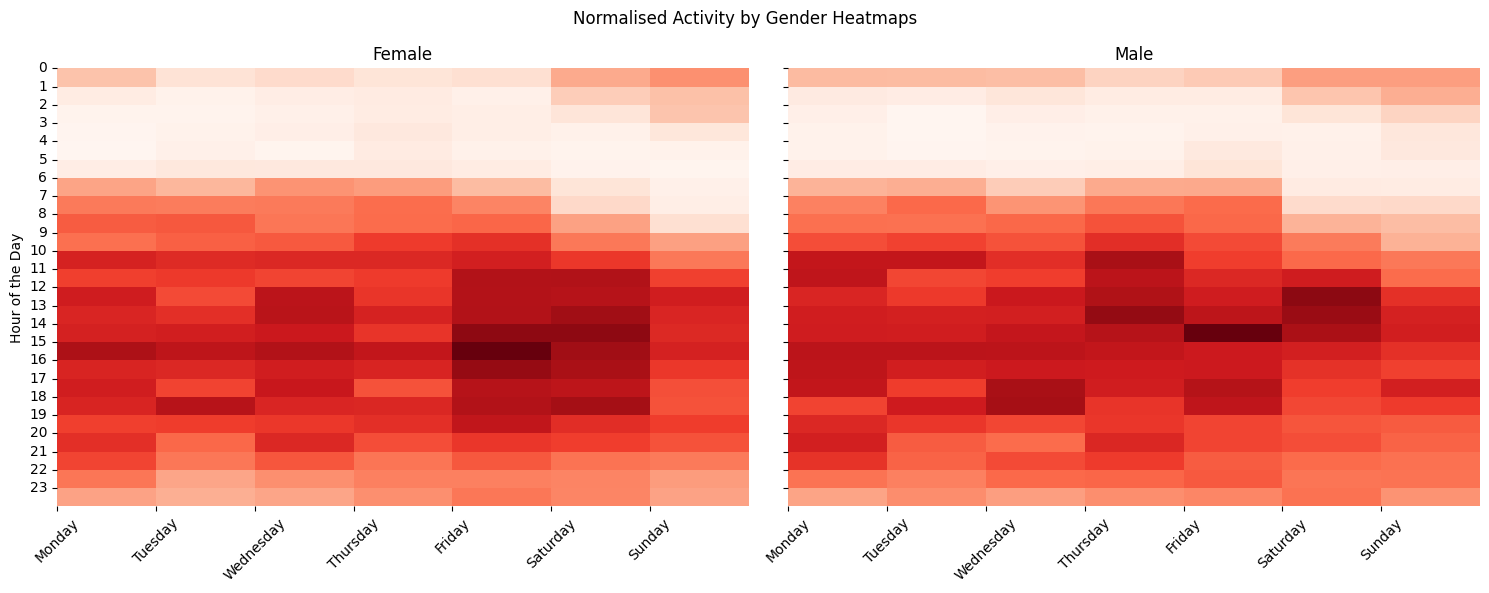

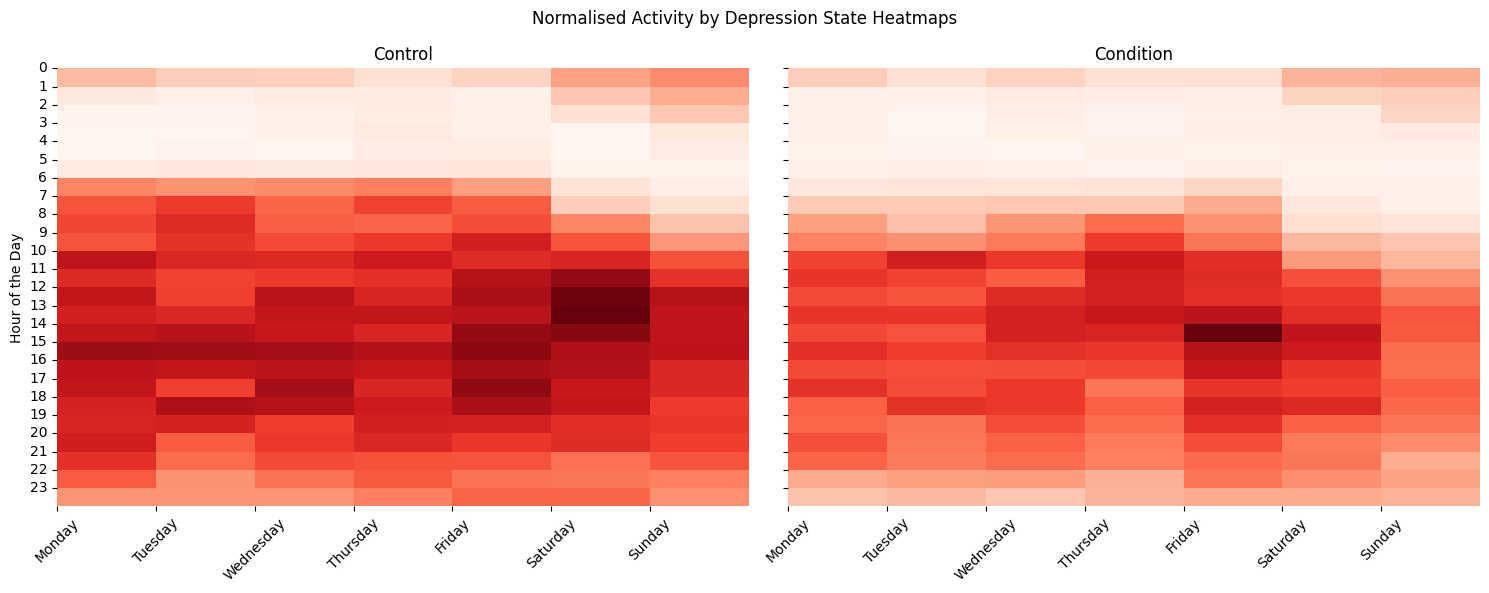

In [3]:
# plot male, female normalised activity heatmaps
plot_heatmap_pair(female_hm_norm, male_hm_norm, df1_title='Female', df2_title='Male', title='Normalised Activity by Gender Heatmaps')

# plot control, condition normalised activity heatmaps
plot_heatmap_pair(control_hm_norm, condition_hm_norm, df1_title='Control', df2_title='Condition', title='Normalised Activity by Depression State Heatmaps')

In [4]:
# list of variable names to delete
hm_dfs = ['control_hm', 'condition_hm', 'female_hm', 'male_hm', 'control_hm_norm', 'condition_hm_norm', 'female_hm_norm', 'male_hm_norm']

# loop over list and delete dfs if they exist
for hm_df in hm_dfs:
    if hm_df in locals():
        del locals()[hm_df]


### Male / Female Activty by Hour of Day

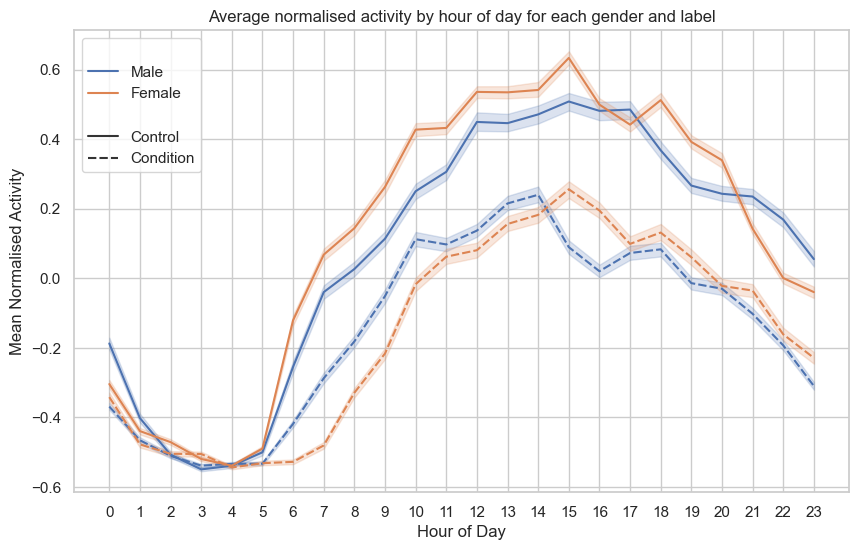

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# map gender and label values to meaningful names
gender_mapping = {1: 'Female', 2: 'Male'}
label_mapping = {0: 'Control', 1: 'Condition'}

# new columns 'gender_name' and 'label_name' with mapped values
df['gender_name'] = df['gender'].map(gender_mapping)
df['label_name'] = df['label'].map(label_mapping)

# plot average normalised activity by hour of day for each gender and label
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x="hour_of_day", y="activity_norm", hue="gender_name", style="label_name", data=df)
plt.title("Average normalised activity by hour of day for each gender and label")

plt.xlabel('Hour of Day')
plt.ylabel('Mean Normalised Activity')

plt.xticks(range(0, 24))

# legend
legend = ax.legend()

# remove extra labels
legend.texts[0].set_text('')
legend.texts[1].set_text('Male')
legend.texts[2].set_text('Female')
legend.texts[3].set_text('')

plt.show()

# list of variable names to delete
var_list = ['gender_mapping', 'label_mapping']
# delete variables if they exist
for var in var_list:
    if var in locals():
        del locals()[var]


In [6]:
# df with mean normalied activity per hour of day for each ID
mean_activity_df = df.groupby(['id', 'hour_of_day','label', 'gender_name', 'label_name'])['activity_norm'].mean().reset_index()

### Visualisations

In [7]:
import pandas as pd
import plotly.express as px

# group by 'gender_name', 'label_name', and 'hour_of_day'
grouped = df.groupby(['gender_name', 'label_name', 'hour_of_day'])['activity'].mean().reset_index()

# interactive line plot
fig = px.line(grouped, x='hour_of_day', y='activity', color='gender_name', line_group='label_name', line_shape='spline', line_dash='label_name')

# update the layout
fig.update_layout(
    title='Average Activity over Time by Gender and Label',
    xaxis_title='Hour of Day',
    yaxis_title='Activity',
    legend_title='Gender',
    hovermode='x unified'
)
# display
fig.show()

In [8]:
import pandas as pd
import plotly.express as px

# group by 'gender_name', 'label_name', and 'hour_of_day'
grouped = df.groupby(['hour_of_day', 'gender_name', 'label_name'])['activity'].mean().reset_index()

# ridgeline plot
fig = px.line(grouped, x='activity', y='hour_of_day', color='gender_name', line_group='label_name', line_shape='linear', line_dash='label_name')

# update the layout
fig.update_layout(
    title='Activity over Time by Gender and Label (Ridgeline Plot)',
    xaxis_title='Activity',
    yaxis_title='Hour of Day',
    legend_title='Gender'
)

# display 
fig.show()

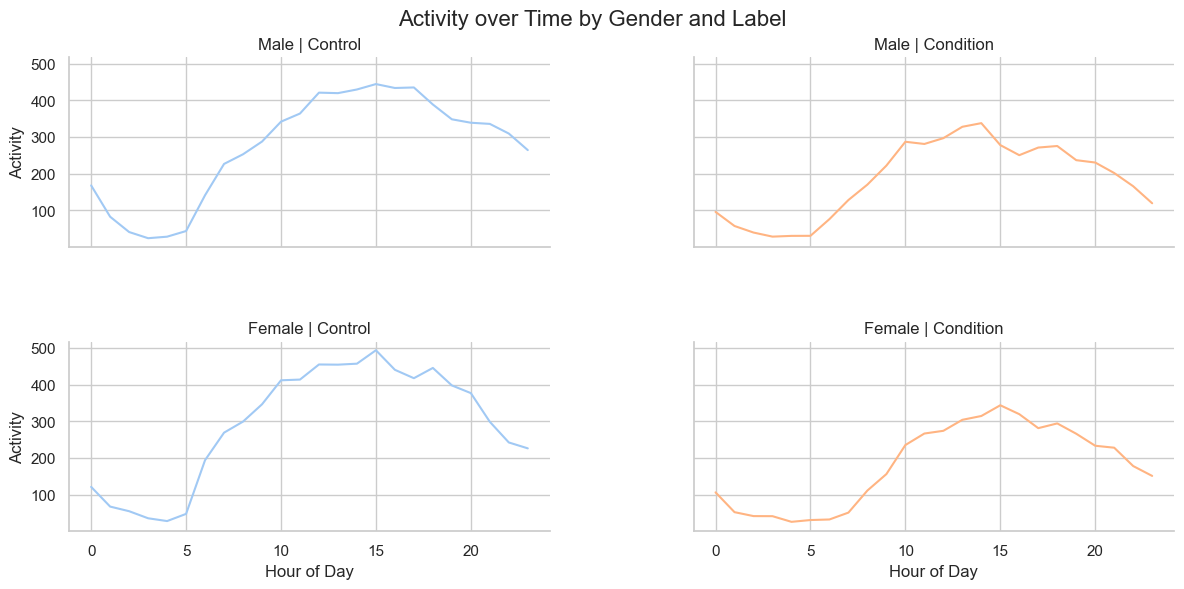

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# facet grid, rows for gender_name and columns for label_name
# set aspect=1 to ensure all plots have the same width
grid = sns.FacetGrid(df, row="gender_name", col="label_name", height=3, aspect=2, hue="label_name", palette='pastel')

# map line plots to grid
grid.map(sns.lineplot, "hour_of_day", "activity", errorbar=None)

# set axis labels and titles
grid.set_axis_labels('Hour of Day', 'Activity')
grid.set_titles(row_template='{row_name}', col_template='{col_name}', size=12)
plt.subplots_adjust(top=0.9, wspace=0.3, hspace=0.5)
grid.figure.suptitle('Activity over Time by Gender and Label', fontsize=16)

# display
plt.show()

In [10]:
plotly_24_hours(mean_activity_df, 'label_name', ['Control', 'Condition'])

plotly_24_hours(mean_activity_df, 'gender_name', ['Female', 'Male'])

In [35]:
# list of variable names to delete
var_list = ['mean_activity_df', 'grouped', 'grid', 'fig']
# delete variables if they exist
for var in var_list:
    if var in locals():
        del locals()[var]

### Descriptive statistics


In [26]:
# create people df
people = df[['id', 'age', 'gender_name', 'label_name']].drop_duplicates()

people2 = df[['id', 'age', 'gender_name', 'label_name', 'date', 'activity', 'activity_norm']].drop_duplicates()

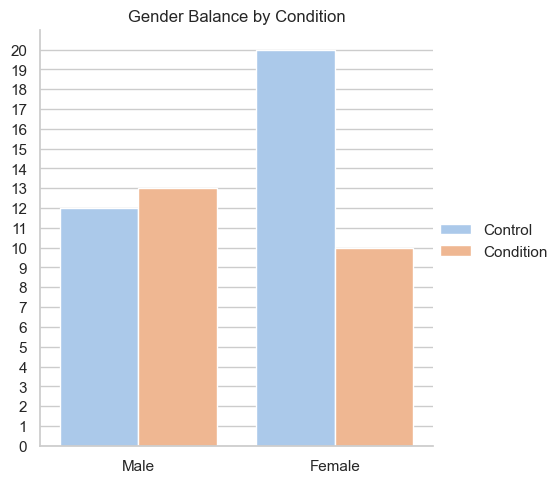

In [27]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.catplot(x="gender_name", hue="label_name", kind="count", palette='pastel', data=people, legend=True)
# title 
plt.title('Gender Balance by Condition')

# remove labels
plt.ylabel('')
plt.xlabel('')
ax._legend.set_title('')

# yticks from 0 to 20
ax.set(yticks=range(0, 21))
ax.set_yticklabels(range(0, 21))  # set ytick labels

# plot
plt.show()

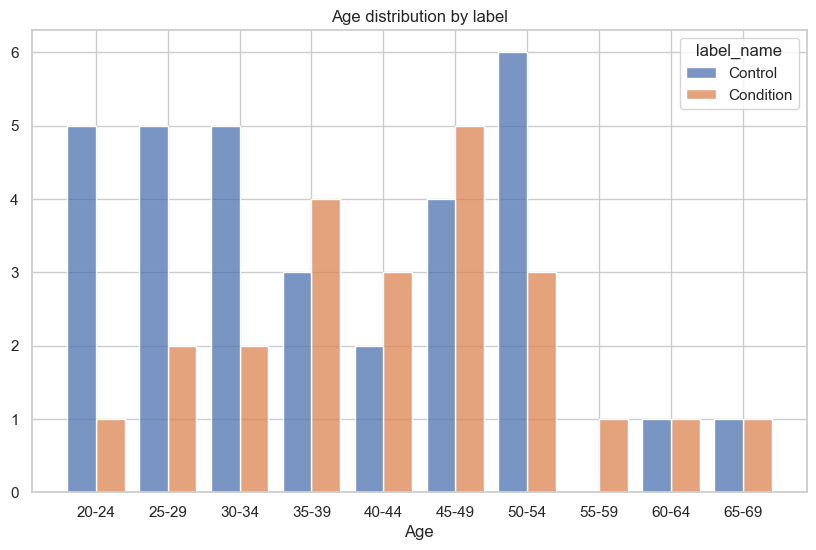

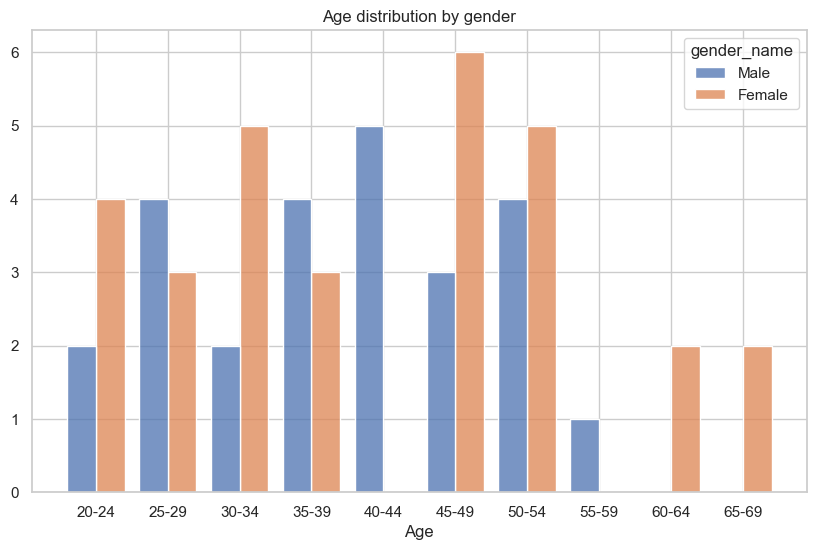

In [28]:
import seaborn as sns
# age correct order
age_order = ['20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69']

# 'age' column to a category type 
people['age'] = pd.Categorical(people['age'], categories=age_order, ordered=True)

import matplotlib.pyplot as plt
# 'age' column to a category type 
people['age'] = pd.Categorical(people['age'], categories=age_order, ordered=True)

# create a new figure for the first plot
plt.figure(figsize=(10, 6))
sns.histplot(data=people, x='age', hue='label_name', multiple='dodge', shrink=.8)
plt.title('Age distribution by label')
plt.xlabel('Age')
plt.ylabel('')
plt.show()

# create a new figure for the second plot
plt.figure(figsize=(10, 6))
sns.histplot(data=people, x='age', hue='gender_name', multiple='dodge', shrink=.8)
plt.title('Age distribution by gender')
plt.xlabel('Age')
plt.ylabel('')
plt.show()

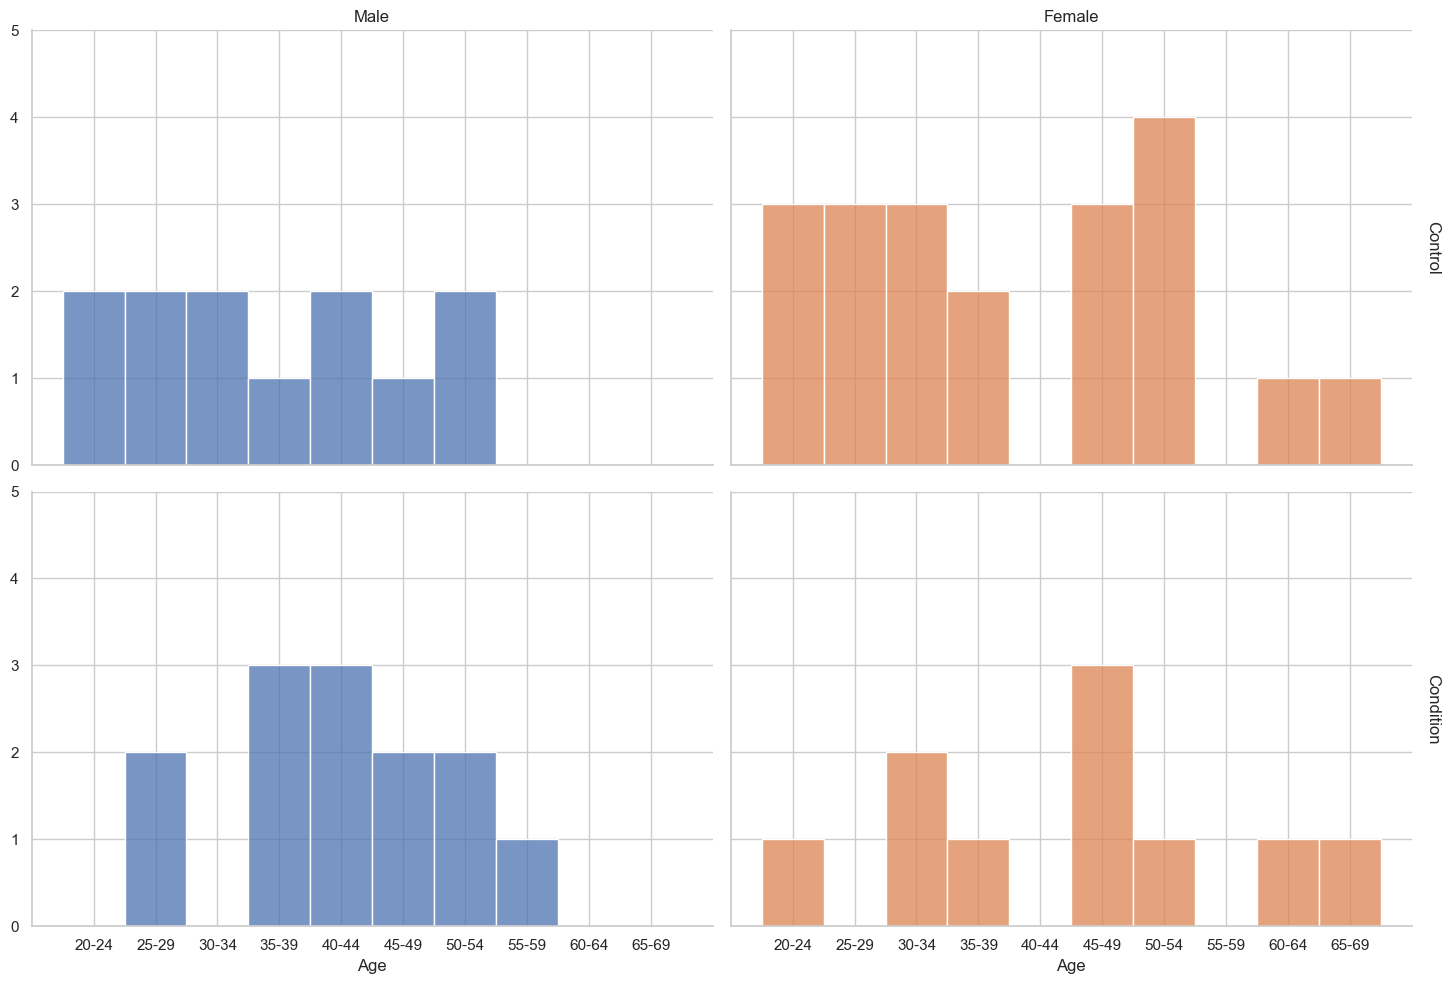

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# set style
sns.set_theme(style="whitegrid")

# facet grid 
g = sns.FacetGrid(people, col='gender_name', row='label_name', hue='gender_name', margin_titles=True, height=5, aspect=1.5)

# histogram to each facet
g.map(sns.histplot, 'age', bins=20)

# set y-axis ticks
for ax in g.axes.flat:
    ax.set_yticks([0, 1, 2, 3, 4, 5])

# legend
#g.add_legend(title='Gender')

# axis labels
g.set_axis_labels('Age', '')

# facet titles
g.set_titles(col_template='{col_name}', row_template='{row_name}')

plt.show()

In [36]:
# male, female dfs
male = people2[people2['gender_name'] == 'Male']
female = people2[people2['gender_name'] == 'Female']

# print count of unique male ids for each label
print("Count of Male Condition/Control IDs:\n")
print("Control: ", len(male[male['label_name']=='Control']['id'].unique()))
print("Condition: ", len(male[male['label_name']=='Condition']['id'].unique()))

# print count of unique female ids for each label
print("\nCount of Female Condition/Control IDs:\n")
print("Control: ", len(female[female['label_name']=='Control']['id'].unique()))
print("Condition: ", len(female[female['label_name']=='Condition']['id'].unique()))

# count of condition/control days for Male
print("\nCount of Male Condition/Control Days:\n")
print("Control: ", len(male[male['label_name']=='Control'].groupby(['id', 'date']).count()))
print("Condition: ", len(male[male['label_name']=='Condition'].groupby(['id', 'date']).count()))

# count of condition/control days for Male
print("\nCount of Female Condition/Control Days:\n")
print("Control: ", len(female[female['label_name']=='Control'].groupby(['id', 'date']).count()))
print("Condition: ", len(female[female['label_name']=='Condition'].groupby(['id', 'date']).count()))



Count of Male Condition/Control IDs:

Control:  12
Condition:  13

Count of Female Condition/Control IDs:

Control:  20
Condition:  10

Count of Male Condition/Control Days:

Control:  150
Condition:  160

Count of Female Condition/Control Days:

Control:  252
Condition:  131


In [32]:
# descriptive statistics for 'male' dataframe
male_desc = male.describe()[['activity', 'activity_norm']]

# descriptive statistics for 'female' dataframe
female_desc = female.describe()[['activity', 'activity_norm']]

# display 
print("Male Descriptive Statistics:")
display(male_desc)
print("\nFemale Descriptive Statistics:")
display(female_desc)


Male Descriptive Statistics:


,activity,activity_norm
count,42347.000000,42347.000000
mean,458.046190,0.542786
min,0.000000,-0.608955
25%,55.000000,-0.470659
50%,205.000000,-0.093490
75%,626.000000,0.965100
max,8000.000000,19.506752
std,617.196121,1.551917



Female Descriptive Statistics:


,activity,activity_norm
count,52193.000000,52193.000000
mean,475.142241,0.585773
min,0.000000,-0.608955
25%,59.000000,-0.460601
50%,216.000000,-0.065830
75%,662.000000,1.055620
max,8000.000000,19.506752
std,623.810348,1.568548


### T-test between groups

In [33]:
# evaluate if there isa statistical differene between genders with t-test
from scipy.stats import ttest_ind
alpha = 0.05

# t-test for activity
t_stat_activity, p_val_activity = ttest_ind(df[df['gender_name']=='Female']['activity'], df[df['gender_name']=='Male']['activity'])
print(f"Activity: t-statistic = {t_stat_activity:.2f}, p-value = {p_val_activity:.2f}")
if p_val_activity < alpha:
    print("Reject the null hypothesis: There is a significant difference between the activity means of the two groups.")

# t-test for normalised activity
t_stat_norm, p_val_norm = ttest_ind(df[df['gender_name']=='Female']['activity_norm'], df[df['gender_name']=='Male']['activity_norm'])
print(f"\nNormalised Activity: t-statistic = {t_stat_norm:.2f}, p-value = {p_val_norm:.2f}")
if p_val_norm < alpha:
    print("Reject the null hypothesis: There is a significant difference between the normalised activity means of the two groups.")

Activity: t-statistic = 32.58, p-value = 0.00
Reject the null hypothesis: There is a significant difference between the activity means of the two groups.

Normalised Activity: t-statistic = 32.58, p-value = 0.00
Reject the null hypothesis: There is a significant difference between the normalised activity means of the two groups.


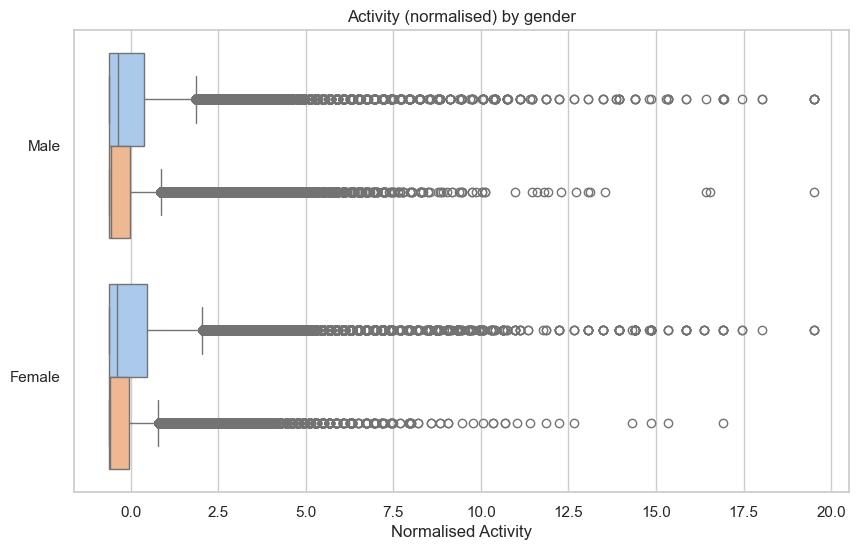

In [145]:
# box plots of activity_norm by gender
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.boxplot(y="gender_name", x="activity_norm", data=df, hue = 'label_name', legend= False, palette='pastel', orient='h')
# labels
#ax.set_yticks([1, 2]) 
#ax.set_yticklabels(['Female', 'Male'])
# remove the y-axis label
ax.set_ylabel('') 
ax.set_xlabel('Normalised Activity')
plt.title("Activity (normalised) by gender")
plt.show()


In [42]:
# list of variable names to delete
var_list = ['people', 'people2', 'ax', 'age_order', 'g', 'male', 'female', 'male_desc', 'female_desc', 't_stat_activity', 'p_val_activity', 't_stat_norm', 'p_val_norm', 'df', 'alpha']
# delete variables if they exist
for var in var_list:
    if var in locals():
        del locals()[var]

## Features

>"Each day was characterized by a feature vector which was computed by extracting a set of features on a per day basis from the activity level. The extracted features were the mean activity level, the corresponding standard deviation and the percentage of events with no activity i.e, activity level = 0. The features were normalized between 0 and 1 before the classification." (Garcia-Ceja et al., 2018)

1. Create baseline features:

* `mean activity level`
* `standard deviation`
* `percentage of events with no activity`

2. Normalise features between 0 and 1



In [82]:
# import from csv
import pandas as pd
input_csv_path = '../data/petter/wiki-08-garcia.csv'
df = pd.read_csv(input_csv_path, parse_dates=['timestamp', 'date'])

In [94]:
# load functions in python file with magic command
%run ../code/wiki-08-base-functions.py

In [85]:
import pandas as pd

# group data by date and id (person and days) or just id (person)
grouped = df.groupby(['date', 'id'])


# features for each date-id combination - mean, std, and percentage of zeros
features = grouped['activity'].agg(['mean', 'std', lambda x: (x == 0).mean()])
features.columns = ['mean_activity', 'std_activity', 'pct_no_activity']

# reset index to make it a regular dataframe
features = features.reset_index()

# join with the original dataframe to get the labels
df_with_features = df.merge(features, on=['id','date'], how='left')

# normalise the features between 0 and 1
df_with_features[['mean_activity', 'std_activity', 'pct_no_activity']] = (
    df_with_features[['mean_activity', 'std_activity', 'pct_no_activity']] - 
    df_with_features[['mean_activity', 'std_activity', 'pct_no_activity']].min()) / (
    df_with_features[['mean_activity', 'std_activity', 'pct_no_activity']].max() - 
    df_with_features[['mean_activity', 'std_activity', 'pct_no_activity']].min())

# drop unnecessary columns
#df_processed = df_with_features.drop(['timestamp', 'activity'], axis=1)
df_processed = df_with_features.drop(['timestamp', 'activity', 'age', 'activity_norm', 'day_of_week', 'hour_of_day'], axis=1)

# remove duplicate rows
df_processed = df_processed.drop_duplicates()

## Split datasets

1. Split by female/male/all
2. Split each into train/test

In [86]:
# create all, male, female dfs
both = df_processed.copy()
male = df_processed[df_processed['gender'] == 2]
female = df_processed[df_processed['gender'] == 1]


In [72]:
# list of variable names to delete
var_list = ['grouped', 'features', 'df_with_features', 'df', 'df_processed']
# delete variables if they exist
for var in var_list:
    if var in locals():
        del locals()[var]

In [87]:
# split each dataset into train and test sets
X_train_both, y_train_both, X_test_both, y_test_both = split_data(both)
X_train_male, y_train_male, X_test_male, y_test_male = split_data(male)
X_train_female, y_train_female, X_test_female, y_test_female = split_data(female)

In [88]:
# print info
print("Both data:")
print(f"Train set: {X_train_both.shape[0]} samples")
print(f"Test set: {X_test_both.shape[0]} samples")
print("\nMale data:")
print(f"Train set: {X_train_male.shape[0]} samples")
print(f"Test set: {X_test_male.shape[0]} samples")
print("\nFemale data:")
print(f"Train set: {X_train_female.shape[0]} samples")
print(f"Test set: {X_test_female.shape[0]} samples")

Both data:
Train set: 554 samples
Test set: 139 samples

Male data:
Train set: 248 samples
Test set: 62 samples

Female data:
Train set: 306 samples
Test set: 77 samples


## Model

1. Single run for each `all`, `female` and `male`
2. Cross validation run?
3. Weighted average run?

In [89]:
models = [
    ('ZeroR', ZeroRClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Linear SVC', LinearSVC(dual=False, max_iter=10000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Neural Network', MLPClassifier(max_iter=1000)),
    ('XGBoost', XGBClassifier()),
    ('LightGBM', LGBMClassifier(verbose=-1)),
    ('AdaBoost', AdaBoostClassifier(algorithm='SAMME')),
    ('QDA', QuadraticDiscriminantAnalysis()),
    ('Gradient Boosting', GradientBoostingClassifier()), 
    ('SVM rbf', SVC(kernel='rbf')),
    ('SVM linear', SVC(kernel='linear')),
    ('Gaussian Process', GaussianProcessClassifier())
]

In [95]:
# empty dictionary to store results
all_results = {}

# single_run for each dataset
for dataset_name in ['both', 'male', 'female']:
    X_train = locals()[f"X_train_{dataset_name}"]
    X_test = locals()[f"X_test_{dataset_name}"]
    y_train = locals()[f"y_train_{dataset_name}"]
    y_test = locals()[f"y_test_{dataset_name}"]

    # single_run 
    results = single_run(X_train, X_test, y_train, y_test, models)

    # store the results in the all_results dictionary
    all_results[dataset_name] = results

# print metrics (dataset, model, metric - can use 'all' for everything) - needs 'all_results' dictionary
print_model_metric(all_results, dataset = 'both', model = 'Random Forest')



both dataset elapsed_time for Random Forest: 0.09426712989807129
both dataset accuracy for Random Forest: 0.7266187050359713
both dataset precision for Random Forest: 0.6326530612244898
both dataset recall for Random Forest: 0.6078431372549019
both dataset f1 for Random Forest: 0.62
both dataset specificity for Random Forest: 0.6078431372549019
both dataset mcc for Random Forest: 0.4068486282170665
both dataset roc_auc for Random Forest: 0.7904411764705881


In [96]:
# print best results for each dataset
for dataset_name, dataset_results in all_results.items():
    for metric in ['accuracy', 'precision', 'recall', 'specificity', 'f1', 'mcc']:
        print_top_models(dataset_name, dataset_results, metric)
    print_second_fastest_model(dataset_name, dataset_results)
    print("\n")


Top 3 models for both dataset based on accuracy:
1. QDA: 0.7769784172661871
2. Gradient Boosting: 0.7482014388489209
3. Naive Bayes: 0.7410071942446043

Top 3 models for both dataset based on precision:
1. QDA: 0.6666666666666666
2. Gradient Boosting: 0.6538461538461539
3. AdaBoost: 0.6530612244897959

Top 3 models for both dataset based on recall:
1. QDA: 0.7843137254901961
2. Naive Bayes: 0.7254901960784313
3. KNN: 0.7058823529411765

Top 3 models for both dataset based on specificity:
1. QDA: 0.7843137254901961
2. Naive Bayes: 0.7254901960784313
3. KNN: 0.7058823529411765

Top 3 models for both dataset based on f1:
1. QDA: 0.7207207207207207
2. Naive Bayes: 0.6727272727272727
3. KNN: 0.6605504587155964

Top 3 models for both dataset based on mcc:
1. QDA: 0.5420313596466879
2. Naive Bayes: 0.463657182321714
3. Gradient Boosting: 0.4602788610832331

Fastest model (elapsed time) for both dataset:
Linear SVC: 0.0



Top 3 models for male dataset based on accuracy:
1. Gradient Boosting:

### Interpretation of Single Run

1. **Performance** overall
* Top performing models vary across the three datasets, suggesting the *potential* influece of gender-specific charactersitics on the model performance
* `Quadratic Discriminant Analysis` (QDA) is exceptionally strong on `both` dataset but does not rank among top models for the gender-specific datasets. `Naive Bayes` and `KNN` also are strong classifiers for the dataset containing both male and female data.
* `AdaBoost`, `LightGBM` and `XGBoost` are strong models for `female` 
* `male` dataset has strong performance with `Gradient Boosting`, `XGBoost` and `Random Forest`.
* This could mean that it is worthwhile pursuing separate models by gender and including additional gender-specific features.
  
1. **Performance** on `both` dataset
* `Quadratic Discriminant Analysis` (QDA) is the top model for all metrics (accuracy, precision, recall, specificity, F1 score and Matthews Correlation Coefficient (MCC))
* `Naive Bayes` performs well - consistently second best model, except for accuracy (3rd) and precision.  It could have issues with false positives.
* `Gradient Boosting` and `AdaBoost` have good precision but lower recall and F1 scores - this could mean a possible bias towards minimising false positives at the expense of detecting fewer true positives.
* `KNN` is fastest model to train

1. **Performance** on `male` dataset
* `Gradient Boosting` and `XGBoost` rank highly across the metrics - suggesting strong performance on the 'male' dataset.
* `Naive Bayes` is fastest model to train
  
1. **Performance** on`female` dataset
* `AdaBoost` model consistently ranks highly (accuracy, precision, f1, MCC) suggesting strong performance on the 'female' dataset
* `LightGBM` and `XGBoost` also perform well across several metrics.
* `Linear SVC` is fastest model to train

1. **Trade-offs**
* There are trade-offs between metrics - this shows the importance of considering multiple metrics and prioritising them against specific requirements and use-cases, especially taking into account the consequences of false positives and false negatives when applying the model - e.g. in a clinical setting. 
* **Precision v Recall**
   * Precision measurees the proportion of true positive instances among all postive predictions; recall measures proportion of actual positive instances which were correctly identified.  
   * Classification models can prioritise precision or recall.
   * **High precision - Low Recall**: when decision threshold for positive classification is very high - that is, conservative at predicting positive instances.
     * For example, high precision is when most predicted depression is true depression, but low recall is when many true depressions are missed.
   * **Low precision - High Recall**: when decision threshold for positive classification is liberal. 
     * Many cases are predicted to be 'depressed' (false positives) when they are not.
   * **F1** - harmonic mean to balance this situation.
   * `male` dataset has high recall (XGBoost at 0.81) but lower precision (0.70)
   * `female` dataset has similar recall and precision for best model (~0.6)
   * **F1**: `female` dataset (0.6) has a lower F1 than `male` (0.75) or `both` (0.71).  This could be due to potential bias or because of underlying differences in the data patterns or distributions.
 * **Accuracy v MCC**
   * Matthews Correlation Coefficient is a powerful metric useed to evaluate binary classification models - especially useful for imbalanced datasets or where false postive / false negative costs are different.  It takes into account all four confusion matrix elements - TP, TN, FP, FN.
   * The MCC is a balanced measure, robust to class imbalance, easy to interpret (-1 to 1) and allows for fair comparison between model performance.
   * For each dataset, the MCC (~0.4-0.5) score is a lot lower than the accuracy (~0.7-0.8).  This could be due to class imbalance or misclassification patterns (bearing in mind very basic features).
   * But `both` has an MCC of 0.54 compared to 0.48 for `female` and `male` which suggests that the `both` model may be performing better - or is there a need for more data (or a different dataset)?

1. **Gender-specific performance differences**
  * The top performing models for each dataset is different - this could indicate that gender-specific models are worth pursuing or warrant further exploration.

2. **Computational efficiency**

  * `KNN` is fastest for `female` dataset; `linear svc` is fastest for `male` and  `both`
  * Needs to be evaluated against other metrics 
  

### Statistical test for signficance

Performing `Wilcoxon rank-sum` (aka Mann-Witney U) to see if there is a statistically significant difference between datast metrics.
* Wilcoxon rank sum is non-parametric (does not assume normal distribution)
* There is no significant difference.
* This could be:
  * Small sample size - one value for each metric of each dataset
  * Magnitude of difference is not large enough
  * Outliers, distributional differences not accounted for (recall, minimal data processing)
  * Significance does not mean that gender-specific models should be abandoned 

In [47]:
import scipy.stats as stats

metrics = ['f1', 'accuracy', 'precision', 'recall', 'specificity', 'mcc']
significant_results_found = False

for model_name, model_results in all_results['both'].items():
    for metric in metrics:
        male_result = all_results['male'][model_name][metric]
        female_result = all_results['female'][model_name][metric]
        all_result = model_results[metric]

        # Perform Wilcoxon rank-sum test
        _, p_val_male = stats.ranksums(male_result, all_result)
        _, p_val_female = stats.ranksums(female_result, all_result)

        if p_val_male < 0.05 or p_val_female < 0.05:
            print(f"Model: {model_name}")
            print(f"Metric: {metric}")
            if p_val_male < 0.05:
                print("The performance on the 'male' dataset is significantly different from the 'all' dataset.")
                print(f"p-value for 'male' vs. 'all': {p_val_male}")
            if p_val_female < 0.05:
                print("The performance on the 'female' dataset is significantly different from the 'all' dataset.")
                print(f"p-value for 'female' vs. 'all': {p_val_female}")
            print("\n")
            significant_results_found = True

if not significant_results_found:
    print("No statistically significant differences were found.")

No statistically significant differences were found.


In [53]:
# prepare all, male, female into dictionary of X and y
datasets = {

    'male': {
        'X': both[both['gender'] == 2][['mean_activity', 'std_activity', 'pct_no_activity']].values,
        'y': both[both['gender'] == 2]['label'].values
    },
    'female': {
        'X': both[both['gender'] == 1][['mean_activity', 'std_activity', 'pct_no_activity']].values,
        'y': both[both['gender'] == 1]['label'].values
    }
}

# update models to dictionary
models = {
    'ZeroR': ZeroRClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Linear SVC': LinearSVC(dual=False, max_iter=10000),
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(max_iter=1000),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(force_col_wise=True, verbose=-1),
    'AdaBoost': AdaBoostClassifier(algorithm='SAMME'),
    'QDA': QuadraticDiscriminantAnalysis(),
    'Gradient Boosting': GradientBoostingClassifier(), 
    'SVM rbf': SVC(kernel='rbf'),
    'SVM linear': SVC(kernel='linear'),
    'Gaussian Process': GaussianProcessClassifier()
}

In [54]:
import scipy.stats as stats
from sklearn.model_selection import StratifiedKFold

metrics = ['f1', 'accuracy', 'precision', 'recall', 'specificity', 'mcc']
num_folds = 5  #  cross-validation folds

for model_name, model in models.items():
    for dataset_name, dataset in datasets.items():
        X, y = dataset['X'], dataset['y']
        cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
        metric_values = []
        significant_difference_found = False  #  flag initialisation

        for train_idx, test_idx in cv.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # metric values for current fold
            metric_values.append({
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred),
                'f1': f1_score(y_test, y_pred),
                'specificity': recall_score(y_test, y_pred, pos_label=1),
                'mcc': matthews_corrcoef(y_test, y_pred)
            })

        # compare metric distributions between datasets
        for metric in metrics:
            dataset_metric_values = [fold_metrics[metric] for fold_metrics in metric_values]
            all_metric_values = all_results['both'][model_name][metric]

            _, p_val = stats.ranksums(dataset_metric_values, all_metric_values)
            if p_val < 0.05:
                print(f"Model: {model_name}")
                print(f"Metric: {metric}")
                print(f"Dataset: {dataset_name}")
                print(f"p-value for comparing with 'all' dataset: {p_val}")
                print("The performance is significantly different from the 'all' dataset.")
                print("\n")
                significant_difference_found = True  # set flag

        if not significant_difference_found:
            print(f"No statistically significant differences were found for model {model_name} on dataset {dataset_name}.")


No statistically significant differences were found for model ZeroR on dataset male.
No statistically significant differences were found for model ZeroR on dataset female.
No statistically significant differences were found for model Random Forest on dataset male.
No statistically significant differences were found for model Random Forest on dataset female.
No statistically significant differences were found for model Linear SVC on dataset male.
No statistically significant differences were found for model Linear SVC on dataset female.
No statistically significant differences were found for model Decision Tree on dataset male.
No statistically significant differences were found for model Decision Tree on dataset female.
No statistically significant differences were found for model Logistic Regression on dataset male.
No statistically significant differences were found for model Logistic Regression on dataset female.
No statistically significant differences were found for model KNN on d

No statistically significant differences with cross-validated (n=5) approach.

### Visualising metrics

In [55]:
import pandas as pd

# empty list 
data = []

# iterate over datasets
for dataset_name, dataset_results in all_results.items():
    # iterate over models
    for model_name, model_results in dataset_results.items():
        # iterate over metrics
        for metric_name, metric_value in model_results.items():
            data.append({
                'model': model_name,
                'metric_name': metric_name,
                'metric_value': metric_value,
                'dataset': dataset_name
            })

# df
singles = pd.DataFrame(data)

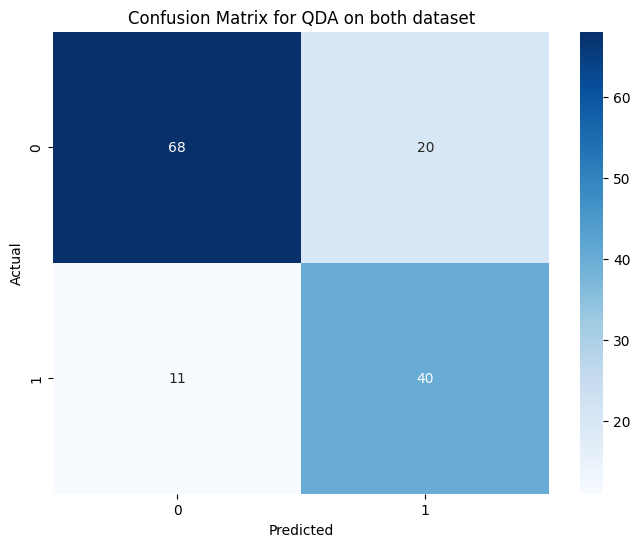

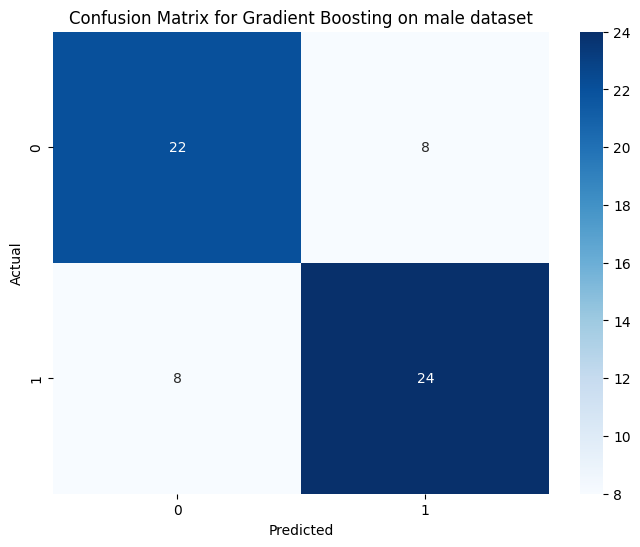

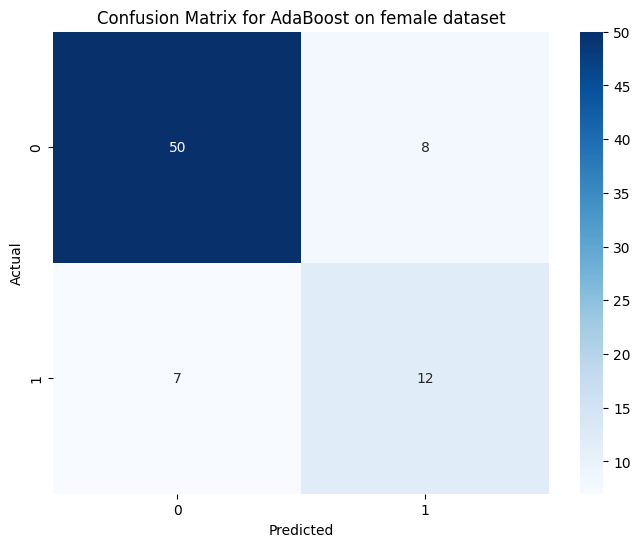

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

for dataset_name, dataset_results in all_results.items():
    # Sort the models based on accuracy
    accuracy_sorted = sorted(dataset_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
    
    # Get the best performing model
    best_model_name, best_model_results = accuracy_sorted[0]
    
    # Plot the confusion matrix
    cm = best_model_results['cm']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.title(f"Confusion Matrix for {best_model_name} on {dataset_name} dataset")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()